# Welcome to project Dionysus!

You were given the challenge of building code that can aggreagte and analyse wine production from many producers.  
Since you want to learn more about wine and automating processes, you accept.

You are given three datasets, [Almeirim.csv](Almeirim.csv), [Benavente.csv](Benavente.csv), and [Cartaxo.csv](Cartaxo.csv)
representing monthly wine bottling output from three small to medium producers.

The data represents historical **monthly** output in thousands of litters, but rough estimates for output.

**All datasets comprise the same time interval!**

These three datasets represent a subset of the **thousands** of datasets you will have to analyse in the future project. **HOWEVER**, these 3 datasets represent the 3 unique configurations for all future dataset analysis.

If your analysis works for these 3, it will work for all future datasets.

To better prepare for future analysis you decide to develop some code to speed things up.

## The Analysis

### Exploration
1. What is the combination of directives and characters that allows you to read the Almeirim.csv item that has temporal information?
1. And for Benavente.csv?
2. And for Cartaxo.csv?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
from statsmodels.tsa.statespace.sarimax import SARIMAX
import glob

In [2]:
df_a = pd.read_csv('data/Almeirim.csv')
df_a.head()

,date,output
0,85-01,72.5052
1,85-02,70.6720
2,85-03,62.4502
3,85-04,57.4714
4,85-05,55.3151


In [3]:
df_b = pd.read_csv('data/Benavente.csv')
df_b.head()

,date,output
0,"Jan,1985",99.178372
1,"Feb,1985",96.736512
2,"Mar,1985",85.540669
3,"Apr,1985",78.774726
4,"May,1985",75.870978


In [4]:
df_c = pd.read_csv('data/Cartaxo.csv')
df_c.head()

,date,output
0,85-01,60.421000
1,85-02,59.042242
2,85-03,52.305336
3,85-04,48.257036
4,85-05,46.563892


In [5]:
# Define accepted date formats
date_formats = ['%y-%m', '%b,%Y', '%Y-%m']

# Safe conversion function
def parse_mixed_date(date_str):
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    raise ValueError(f"Unrecognized date format: '{date_str}'")

In [6]:
# Load CSVs with 'date' as string, then convert
def load_wine_data(filepath):
    df = pd.read_csv(filepath)
    df['date'] = df['date'].apply(parse_mixed_date)
    return df

In [7]:
# Read CSVs using the safe parser
almeirim_df = load_wine_data('data/Almeirim.csv')
benavente_df = load_wine_data('data/Benavente.csv')
cartaxo_df = load_wine_data('data/Cartaxo.csv')

In [8]:
almeirim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    396 non-null    datetime64[ns]
 1   output  396 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [9]:
cartaxo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    396 non-null    datetime64[ns]
 1   output  396 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


#### Initializing
When initialized, the class must have as arguments:
1. A __filename__ parameter, without a default argument.
1. A __label__ parameter with a default value of "Producer".
1. Make sure the former two arguments are stored as attributes of the class.
1. Check if the path to __filename__ exists. If it does, it should be stored as and attribute called __df__, which should be a pandas dataframe. If it is not found, the code should __raise__ a _FileNotFoundError_ with an appropriate message.

In [10]:
class Wine:
    """
    A class to facilitate analysis of wine production data with automatic date parsing.

    Attributes
    ----------
    filename : str
        The path to the CSV file containing the wine production data.
    label : str
        A label for the producer.
    df : pd.DataFrame
        A dataframe containing the wine production data, loaded from the specified file.

    Methods
    -------
    __init__(self, filename, label="Producer")
        Constructor for the Wine class that loads data from a specified CSV file with automatic date parsing.
    """

    # List of accepted date formats
    date_formats = ['%y-%m', '%b,%Y', '%Y-%m']

    @staticmethod
    def parse_mixed_date(date_str):
        """
        Attempts to parse a date string using known formats.
        Raises a ValueError if none of the formats match.
        """
        for fmt in Wine.date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                continue
        raise ValueError(f"Unrecognized date format: '{date_str}'")

    def __init__(self, filename, label="Producer"):
        """
        Initializes the Wine object, loading wine production data from a CSV file.

        Parameters
        ----------
        filename : str
            The path to the CSV file containing the wine production data.
        label : str, optional
            A label for the producer. Default is "Producer".

        Raises
        ------
        FileNotFoundError
            If the specified file cannot be found.
        ValueError
            If date parsing fails for any row.
        """
        self.filename = filename
        self.label = label

        # Check if the file exists
        if not os.path.exists(self.filename):
            raise FileNotFoundError(f"The file {self.filename} does not exist.")

        # Load data and convert 'date' column
        self.df = pd.read_csv(self.filename)

        if 'date' not in self.df.columns:
            raise ValueError(f"'date' column not found in {self.filename}")

        self.df['date'] = self.df['date'].apply(Wine.parse_mixed_date)


In [11]:
#check the date format
test_wine = Wine('data/Almeirim.csv')
test_wine.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396 entries, 0 to 395
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    396 non-null    datetime64[ns]
 1   output  396 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


#### Report
Write a __report__ method to analyze data and create a report.
1. The method should have a __start_date__ argument with a default value of "1990-01-01".
1. The method should have an __end_date__ argument with a default value of "2018-01-01".
1. If __start_date__ or __end_date__ are not of type string, raise a TypeError with message "Both temporal arguments must be strings".
1. If __start_date__ or __end_date__ don't have a length of 10, raise an Exception with message "Both arguments must have length 10."
1. If you try to convert __start_date__ to a temporal format and you fail, raise an Exception with message "Can't convert start_date to temporal format"
1. If you try to convert __end_date__ to a temporal format and you fail, raise an Exception with message "Can't convert end_date to temporal format"
1. The method should __print__ a __description__ of the dataframe, filtered between __start_date__ and __end_date__.
1. Write a one line docstring for the method.

In [12]:
class Wine:
    """
    A class to facilitate analysis of wine production data with automatic date parsing.

    Attributes
    ----------
    filename : str
        The path to the CSV file containing the wine production data.
    label : str
        A label for the producer.
    df : pd.DataFrame
        A dataframe containing the wine production data, loaded from the specified file.

    Methods
    -------
    __init__(self, filename, label="Producer")
        Loads data and parses dates safely.
    report(start_date="1990-01-01", end_date="2018-01-01")
        Prints summary statistics for the selected date range.
    """

    # Supported date formats
    date_formats = ['%y-%m', '%b,%Y', '%Y-%m']

    @staticmethod
    def parse_mixed_date(date_str):
        """
        Attempts to parse a date string using known formats.
        Raises a ValueError if none of the formats match.
        """
        for fmt in Wine.date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                continue
        raise ValueError(f"Unrecognized date format: '{date_str}'")

    def __init__(self, filename, label="Producer"):
        """
        Initializes the Wine object and parses dates.

        Parameters
        ----------
        filename : str
            Path to the CSV file.
        label : str, optional
            Name of the producer. Default is "Producer".

        Raises
        ------
        FileNotFoundError
            If the file is not found.
        ValueError
            If the 'date' column is missing or unparseable.
        """
        self.filename = filename
        self.label = label

        if not os.path.exists(self.filename):
            raise FileNotFoundError(f"The file {self.filename} does not exist.")

        self.df = pd.read_csv(self.filename)

        if 'date' not in self.df.columns:
            raise ValueError(f"'date' column not found in {self.filename}")


### Forecast
Since you want to see into the future, you make a forecast method using a **SARIMAX** from [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html).
1. Define a forecast method with two arguments: a __start_date__ with default value '2018-01-01' and a **periods** with a default value 24.
2. Declare a variable **mod** and make it equal to a SARIMAX object with 3 parameters: the column 'output' of the dataframe (self.df), *order* set to (2,1,1) and *seasonal_order* set to (1,1,1,12), because we have yearly repetition.
3. Declare a variable **res** equal to the result of the ".fit" method from **mod**.
4. Declare a variable called **output_hat** equal to the prediction (res.predict) with two parameters: the length of the dataframe and the length of the dataframe plus the **periods-1** (to get dimensions right).
5. Declare a variable called **time_hat** equal to a pandas daterange with *start* as __start_date__, *periods* as __periods__ and **freq** to the start of the month, 'MS'.
6.  Make a dataframe called **df_pred** with **time_hat** and **output_hat** as columns.
7.  Plot both self.df and df_pred.

In [13]:
class Wine:
    """
    A class designed to expedite and scale wine production data analysis.

    Attributes
    ----------
    filename : str
        The path to the CSV file containing the wine production data.
    label : str
        A label for the producer.
    df : pd.DataFrame
        A dataframe containing the wine production data, loaded from the specified file.

    Methods
    -------
    __init__(self, filename, label="Producer")
        Initializes the Wine object, loading data from a CSV file.
        
    report(self, start_date, end_date)
        Generates a report of wine production data within a specified date range.

    forecast(self, start_date='2018-01-01', periods=24)
        Forecasts future wine production using a SARIMAX model.
    """

    date_formats = ['%y-%m', '%b,%Y', '%Y-%m']

    @staticmethod
    def parse_mixed_date(date_str):
        """
        Attempts to parse a date string using known formats.
        Raises a ValueError if none of the formats match.
        """
        for fmt in Wine.date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                continue
        raise ValueError(f"Unrecognized date format: '{date_str}'")

    def __init__(self, filename, label="Producer"):
        """
        Initializes the Wine object, loading wine production data from a CSV file.
        """
        self.filename = filename
        self.label = label

        if not os.path.exists(self.filename):
            raise FileNotFoundError(f"The file {self.filename} does not exist.")

        self.df = pd.read_csv(self.filename)

        if 'date' not in self.df.columns:
            raise ValueError(f"'date' column not found in {self.filename}")

        self.df['date'] = self.df['date'].apply(Wine.parse_mixed_date)

    def report(self, start_date="1990-01-01", end_date="2018-01-01"):
        """
        Generates a report of the wine production data within a specified date range.
        """
        if not isinstance(start_date, str) or not isinstance(end_date, str):
            raise TypeError("Both temporal arguments must be strings")

        if len(start_date) != 10 or len(end_date) != 10:
            raise ValueError("Both arguments must have length 10.")

        try:
            start_date_parsed = pd.to_datetime(start_date)
        except ValueError:
            raise ValueError("Can't convert start_date to temporal format")

        try:
            end_date_parsed = pd.to_datetime(end_date)
        except ValueError:
            raise ValueError("Can't convert end_date to temporal format")

        filtered_df = self.df[
            (self.df['date'] >= start_date_parsed) & (self.df['date'] <= end_date_parsed)
        ]

        print(filtered_df.describe())

    def forecast(self, start_date='2018-01-01', periods=24):
        """
        Forecasts future wine production using SARIMAX model.
        """
        mod = SARIMAX(self.df['output'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))

        try:
            res = mod.fit()
        except Exception as exc:
            raise ValueError(f"Error fitting SARIMAX model: {exc}") from exc

        try:
            output_hat = res.predict(start=len(self.df), end=len(self.df) + periods - 1)
        except Exception as exc:
            raise ValueError(f"Error predicting future values: {exc}") from exc

        time_hat = pd.date_range(start=start_date, periods=periods, freq='MS')
        df_pred = pd.DataFrame({'date': time_hat, 'output': output_hat}).set_index('date')

        plt.figure(figsize=(10, 6))
        plt.plot(self.df['date'], self.df['output'], label='Historical')
        plt.plot(df_pred.index, df_pred['output'], label='Forecast', linestyle='--')
        plt.legend()
        plt.title(f'{self.label} Wine Production Forecast')
        plt.xlabel('Date')
        plt.ylabel('Output')
        plt.show()

### Deploy 
We want to run our class for all files we might encounter in the future, not just the ones in the exercise.

1. Outside of the class definition, build a list of all the __.csv__ files you have in your current directory. Not manually, make sure you find a python way to do it automatically.
2. Make a **for** cycle where you iterate over every file in the list.
3. Extract the name of the producer from the filename (everything before _.csv_) and store it in a variable called __label__.
4. Declare a class instance of __Wine__ called __winemaker__. The arguments should be the __filename__ you are listing over and the __label__ you just declared. 

In [14]:
class Wine:
    """
    A class designed to expedite and scale wine production data analysis.

    Attributes
    ----------
    filename : str
        The path to the CSV file containing the wine production data.
    label : str
        A label for the producer.
    df : pd.DataFrame
        A dataframe containing the wine production data, loaded from the specified file.

    Methods
    -------
    __init__(self, filename, label="Producer")
        Initializes the Wine object, loading data from a CSV file.
        
    report(self, start_date, end_date)
        Generates a report of wine production data within a specified date range.

    forecast(self, start_date='2018-01-01', periods=24)
        Forecasts future wine production using a SARIMAX model.
    """

    date_formats = ['%y-%m', '%b,%Y', '%Y-%m']

    @staticmethod
    def parse_mixed_date(date_str):
        """
        Attempts to parse a date string using known formats.
        Raises a ValueError if none of the formats match.
        """
        for fmt in Wine.date_formats:
            try:
                return pd.to_datetime(date_str, format=fmt)
            except ValueError:
                continue
        raise ValueError(f"Unrecognized date format: '{date_str}'")

    def __init__(self, filename, label="Producer"):
        self.filename = filename
        self.label = label

        if not os.path.exists(self.filename):
            raise FileNotFoundError(f"The file {self.filename} does not exist.")

        self.df = pd.read_csv(self.filename)

        if 'date' not in self.df.columns:
            raise ValueError(f"'date' column not found in {self.filename}")

        self.df['date'] = self.df['date'].apply(Wine.parse_mixed_date)

    def report(self, start_date="1990-01-01", end_date="2018-01-01"):
        """
        Generates a report of the wine production data within a specified date range.
        """
        if not isinstance(start_date, str) or not isinstance(end_date, str):
            raise TypeError("Both temporal arguments must be strings")

        if len(start_date) != 10 or len(end_date) != 10:
            raise ValueError("Both arguments must have length 10.")

        try:
            start_date_parsed = pd.to_datetime(start_date)
        except ValueError:
            raise ValueError("Can't convert start_date to temporal format")

        try:
            end_date_parsed = pd.to_datetime(end_date)
        except ValueError:
            raise ValueError("Can't convert end_date to temporal format")

        filtered_df = self.df[
            (self.df['date'] >= start_date_parsed) & (self.df['date'] <= end_date_parsed)
        ]

        print(filtered_df.describe())

    def forecast(self, start_date='2018-01-01', periods=24):
        """
        Forecasts future wine production using SARIMAX model.

        Parameters
        ----------
        start_date : str, optional
            The start date for forecasting. Default is '2018-01-01'.
        periods : int, optional
            The number of periods to forecast. Default is 24.
        """
        mod = SARIMAX(self.df['output'], order=(2, 1, 1), seasonal_order=(1, 1, 1, 12))

        try:
            res = mod.fit()
        except Exception as exc:
            raise ValueError(f"Error fitting SARIMAX model: {exc}") from exc

        try:
            output_hat = res.predict(start=len(self.df), end=len(self.df) + periods - 1)
        except Exception as exc:
            raise ValueError(f"Error predicting future values: {exc}") from exc

        time_hat = pd.date_range(start=start_date, periods=periods, freq='MS')
        df_pred = pd.DataFrame({'date': time_hat, 'output': output_hat}).set_index('date')

        plt.figure(figsize=(10, 6))
        plt.plot(self.df['date'], self.df['output'], label='Historical')
        plt.plot(df_pred.index, df_pred['output'], label='Forecast', linestyle='--')
        plt.legend()
        plt.title(f'{self.label} Wine Production Forecast')
        plt.xlabel('Date')
        plt.ylabel('Output')
        plt.show()

Generating report for Almeirim:
                      date      output
count                  336  336.000000
mean   2003-12-16 11:00:00   92.726822
min    1990-01-01 00:00:00   65.821800
25%    1996-12-24 06:00:00   83.990550
50%    2003-12-16 12:00:00   92.069600
75%    2010-12-08 18:00:00  102.169900
max    2017-12-01 00:00:00  124.254900
std                    NaN   12.736687
Forecasting production for Almeirim:
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.31014D+00    |proj g|=  9.01249D-02


 This problem is unconstrained.



At iterate    5    f=  2.26598D+00    |proj g|=  4.32190D-02

At iterate   10    f=  2.23323D+00    |proj g|=  2.49907D-02

At iterate   15    f=  2.21855D+00    |proj g|=  3.44103D-03

At iterate   20    f=  2.21851D+00    |proj g|=  2.96998D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   2.970D-06   2.219D+00
  F =   2.2185088647373776     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


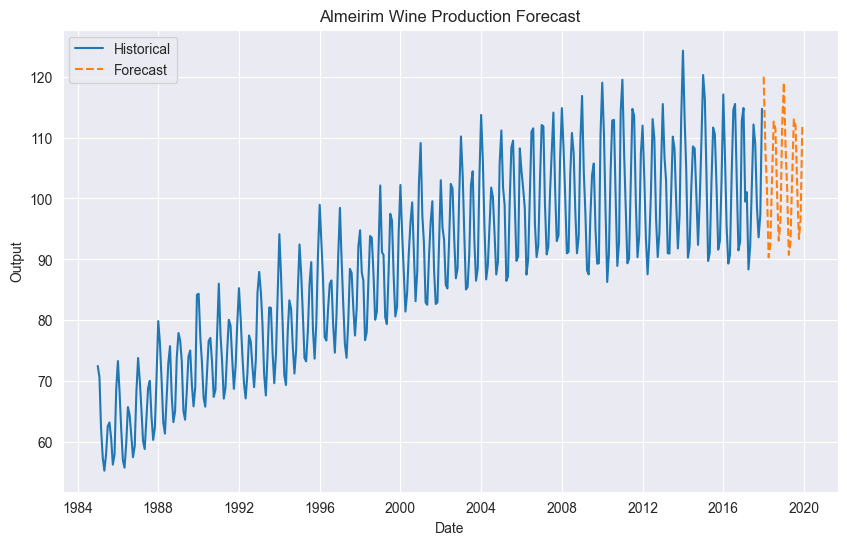

Generating report for Cartaxo:
                      date      output
count                  336  336.000000
mean   2003-12-16 11:00:00  144.759712
min    1990-01-01 00:00:00   64.472946
25%    1996-12-24 06:00:00  101.435322
50%    2003-12-16 12:00:00  142.151281
75%    2010-12-08 18:00:00  182.889234
max    2017-12-01 00:00:00  259.215050
std                    NaN   49.908290
Forecasting production for Cartaxo:
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83829D+00    |proj g|=  6.34746D-02



 This problem is unconstrained.


At iterate    5    f=  2.80756D+00    |proj g|=  6.25736D-02

At iterate   10    f=  2.76360D+00    |proj g|=  3.24817D-02

At iterate   15    f=  2.75239D+00    |proj g|=  2.88478D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     21      1     0     0   1.387D-06   2.752D+00
  F =   2.7523839938593881     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


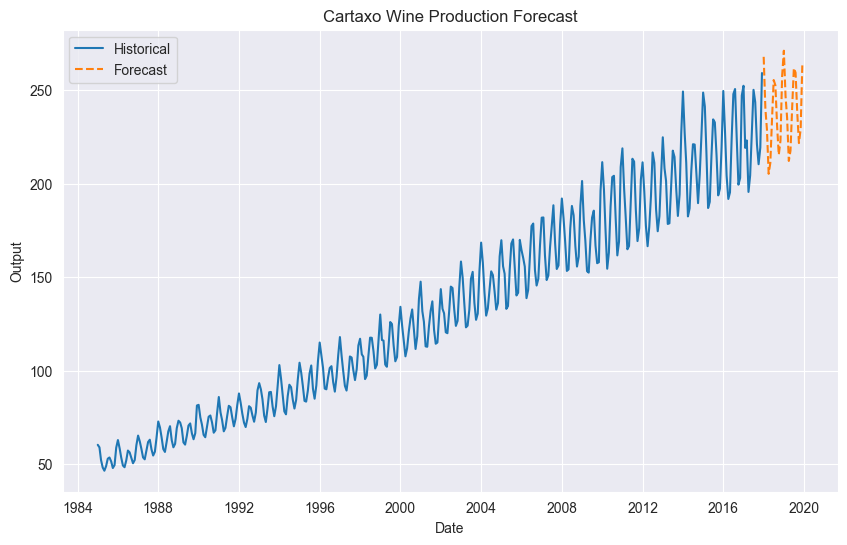

Generating report for Benavente:
                      date      output
count                  336  336.000000
mean   2003-12-16 11:00:00  156.631769
min    1990-01-01 00:00:00   94.283726
25%    1996-12-24 06:00:00  128.544381
50%    2003-12-16 12:00:00  156.591157
75%    2010-12-08 18:00:00  182.540661
max    2017-12-01 00:00:00  234.325610
std                    NaN   33.688985
Forecasting production for Benavente:
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84851D+00    |proj g|=  4.62468D-02


 This problem is unconstrained.



At iterate    5    f=  2.81032D+00    |proj g|=  4.96578D-02

At iterate   10    f=  2.77384D+00    |proj g|=  6.69948D-02

At iterate   15    f=  2.75628D+00    |proj g|=  5.35622D-03

At iterate   20    f=  2.75605D+00    |proj g|=  2.41228D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     23      1     0     0   1.335D-05   2.756D+00
  F =   2.7560484910036642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


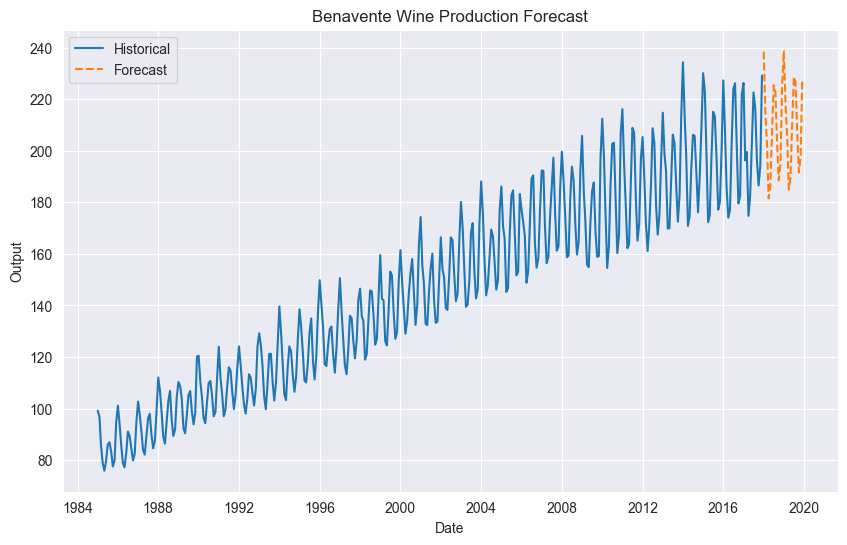

In [15]:
# List all .csv files in the current directory
csv_files = glob.glob('data/*.csv')

# Iterate over each file in the list
for filename in csv_files:
    # Extract the name of the producer from the filename (everything before .csv)
    label = os.path.basename(filename).split('.')[0]
    
    # Declare a class instance of Wine called winemaker
    winemaker = Wine(filename=filename, label=label)
    
    # Generate a report for the producer
    print(f"Generating report for {label}:")
    winemaker.report() 
    
    print(f"Forecasting production for {label}:")
    winemaker.forecast() 